In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

from scipy import signal

In [2]:
xtarget = np.array([0.5, 1.5, 5.0, 10.0, 100.0]) * 1e-03
ytarget_db = np.array([-17.0, -9.0, -4.0, -2.0, 0.0])
ytarget = np.power(10, ytarget_db / 20.0)

In [211]:
fs = 32000
freq = 1000

t = np.arange(0, int(0.100*fs)) #100ms
sine = np.sin(2.0 * np.pi * freq * t / fs)
sig01 = np.append(np.append(np.zeros(int(0.010*fs)), sine), np.zeros_like(sine) )
tim01 = np.linspace(0.0, 0.210, int(0.210*fs))

sig02 = np.abs(sig01)

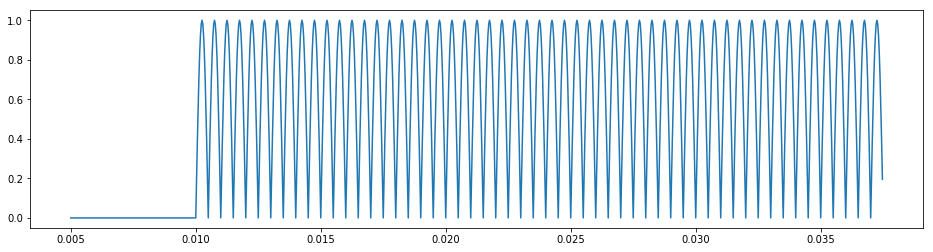

In [581]:
plt.figure(figsize=(16, 4))
plt.plot(tim01[160:1200], sig02[160:1200])
plt.show()

In [212]:
%%time
filt01 = np.zeros_like(sig01)
filt02 = np.zeros_like(sig01)
rel = 0.99875 #jmeter ** 4
a1 = 0.0017451222760092025 #14Hz
a2 = 0.025585872583903095 #80Hz
y1, y2 = 0.0, 0.0
t = 0

for i, x in np.ndenumerate(sig02):
    y1 = rel * y1
    y2 = rel * y2
    if x > y1:
        y1 += a1 * (x - y1)
    if x > y2: 
        y2 += a2 * (x - y2)
    filt01[i] = y1
    filt02[i] = y2
alpha = 0.666
res = alpha * filt01 + (1-alpha) * filt02

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.85 ms


In [591]:
gain = np.max(res)
gain

0.5470397550735818

In [592]:
0.0017451222760092025 * fs, 0.025585872583903095 * fs

(55.84391283229448, 818.7479226848991)

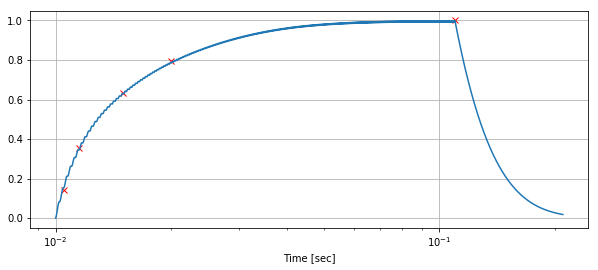

In [593]:
gain = 0.5482122768340246 #1kHz

plt.figure(figsize=[10,4])
plt.plot(xtarget + 0.01, ytarget, 'rx')
plt.plot(tim01[320:6800], res[320:6800] / gain)
plt.xlabel('Time [sec]'); plt.xscale('log'); plt.grid()
plt.show()

## Good compromise -- slower release time

In [213]:
%%time
filt01 = np.zeros_like(sig01)
filt02 = np.zeros_like(sig01)
rel = 0.99985 #slower release
a1 = 200.0 / fs #210
a2 = 980.0 / fs #1100  960
alpha = 0.60 #0.6666  0.60
y1, y2 = 0.0, 0.0
t = 0

for i, x in np.ndenumerate(sig02):
    y1 = rel * y1
    y2 = rel * y2
    if x > y1:
        y1 += a1 * (x - y1)
    if x > y2: 
        y2 += a2 * (x - y2)
    filt01[i] = y1
    filt02[i] = y2

res = alpha * filt01 + (1 - alpha) * filt02

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.11 ms


In [214]:
gain = np.max(res)
gain

0.9215838347691006

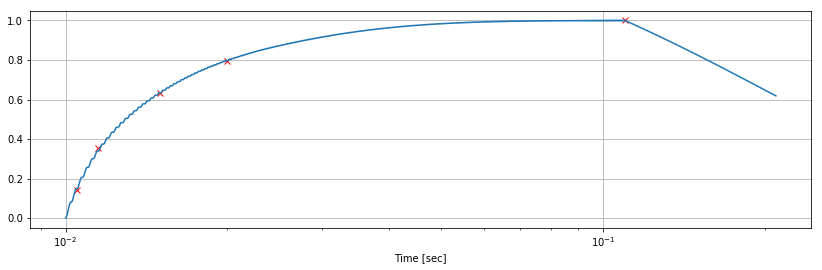

In [210]:
#gain = 0.9197849694819198
plt.figure(figsize=[14,4])
plt.plot(xtarget + 0.01, ytarget, 'rx')
plt.plot(tim01[320:6800], res[320:6800] / gain)
plt.xlabel('Time [sec]'); plt.xscale('log'); plt.grid()
plt.show()

### critical values

In [693]:
res[-1] / gain

0.6182852549003148

In [694]:
20 * np.log10(res[-1] / gain)

-4.176222211920824

In [696]:
# release dB / sec
-4.1762 * 10

-41.762

## delayed release

In [675]:
%%time
filt01 = np.zeros_like(sig01)
filt02 = np.zeros_like(sig01)
rel1 = 0.99875
a1 = 0.0087 #280.0 / fs
a2 = 0.0335 #80Hz
w1, w2, y1, y2, z1, z2 = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
t1, t2 = 0, 0
dt = 0.01 * fs # 10ms delay

for i, x in np.ndenumerate(sig02):
    if t1 == 0:
        y1 = rel1 * y1
    if t2 == 0:
        y2 = rel1 * y2
    if x > y1:
        y1 += a1 * (x - y1)
        t1 = dt
    if x > y2: 
        y2 += a2 * (x - y2)
        t2 = dt
    filt01[i] = y1
    filt02[i] = y2
    if t1 > 0: t1 -= 1
    if t2 > 0: t2 -= 1
alpha = 0.6666
res = alpha * filt01 + (1-alpha) * filt02

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.76 ms


In [676]:
gain = np.max(res)
gain

0.9923559437001874

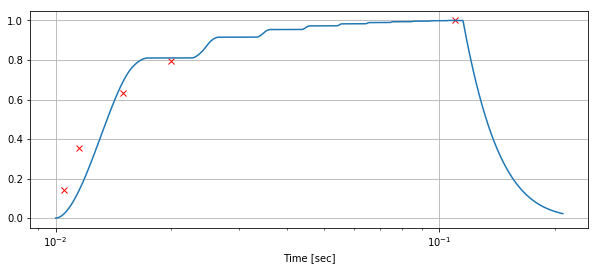

In [677]:
#gain = 0.9914201236654254
plt.figure(figsize=[10,4])
plt.plot(xtarget + 0.01, ytarget, 'rx')
plt.plot(tim01[320:6800], res[320:6800] / gain)
plt.xlabel('Time [sec]'); plt.xscale('log'); plt.grid()
plt.show()

## delayed release v2
The attack curve changes with the frequency

In [648]:
%%time
filt01 = np.zeros_like(sig01)
filt02 = np.zeros_like(sig01)
rel1 = 0.99875
a1 = 0.0085 #14Hz
a2 = 0.0325 #80Hz
w1, w2, y1, y2, z1, z2 = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
t1, t2 = 1.0, 1.0

for i, x in np.ndenumerate(sig02):
    if t1 >= 1.0:
        y1 = rel1 * y1
        z1 = y1
    else:
        y1 = y1 * (1 - 0.001 * t1)#0.9998
    if t2 >= 1.0:
        y2 = rel1 * y2
        z2 = y2
    else:
        y2 = y2 * (1 - 0.001 * t2)#* (1 - 0.1 * t2)
    if x > y1:
        y1 += a1 * (x - y1)
        t1 = 0.0
    if x > y2: 
        y2 += a2 * (x - y2)
        t2 = 0.0
    filt01[i] = y1
    filt02[i] = y2
    if t1 < 1: t1 += 0.001
    if t2 < 1: t2 += 0.001
alpha = 0.6666
res = alpha * filt01 + (1-alpha) * filt02

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.32 ms


In [649]:
gain = np.max(res)
gain

0.9660467797720783

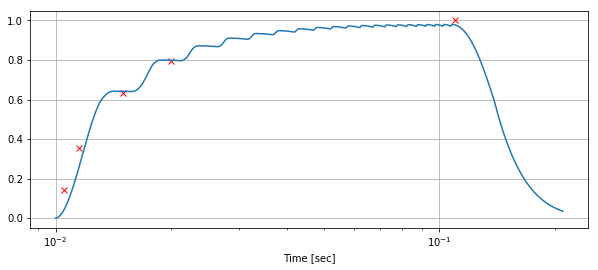

In [650]:
gain = 0.9860574340251814
plt.figure(figsize=[10,4])
plt.plot(xtarget + 0.01, ytarget, 'rx')
plt.plot(tim01[320:6800], res[320:6800] / gain)
plt.xlabel('Time [sec]'); plt.xscale('log'); plt.grid()
plt.show()

## JMeter type release

In [682]:
# release 24db in 2.8s
reldbps = 24 / 2.8
reldbsamp = 24 / (2.8 * 32000)
10 ** (-reldbsamp / 20)

0.9999691622822825

In [678]:
%%time
filt01 = np.zeros_like(sig01)
filt02 = np.zeros_like(sig01)
rel = 0.99875 #
a1 = 0.0060 #14Hz
a2 = 0.0355 #80Hz
y1, y2 = 0.0, 0.0
t = 0

for i, x in np.ndenumerate(sig02):
    if t > 4:
        y1 = rel * y1
        y2 = rel * y2
        t = 0
    if x > y1:
        y1 += a1 * (x - y1)
    if x > y2: 
        y2 += a2 * (x - y2)
    filt01[i] = y1
    filt02[i] = y2
    t += 1
alpha = 0.6666
res = alpha * filt01 + (1-alpha) * filt02

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.4 ms


In [679]:
gain = np.max(res)
gain

0.9039879146004283

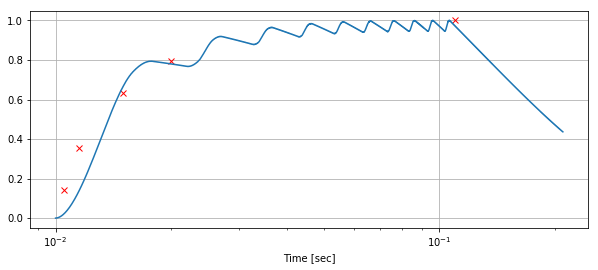

In [681]:
#gain = 0.9197849694819198
plt.figure(figsize=[10,4])
plt.plot(xtarget + 0.01, ytarget, 'rx')
plt.plot(tim01[320:6800], res[320:6800] / gain)
plt.xlabel('Time [sec]'); plt.xscale('log'); plt.grid()
plt.show()

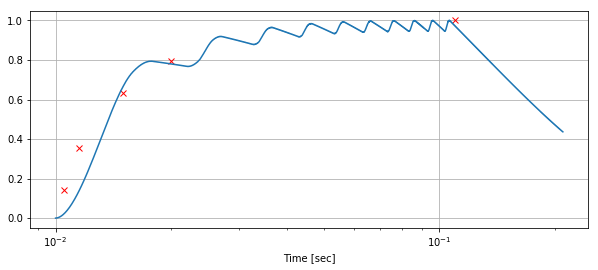

In [681]:
#gain = 0.9197849694819198
plt.figure(figsize=[10,4])
plt.plot(xtarget + 0.01, ytarget, 'rx')
plt.plot(tim01[320:6800], res[320:6800] / gain)
plt.xlabel('Time [sec]'); plt.xscale('log'); plt.grid()
plt.show()